# Exploratory Data Analysis
---

In [1]:
import os
import duckdb

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

/tmp/ipykernel_214/4129410347.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")


### Missing Values

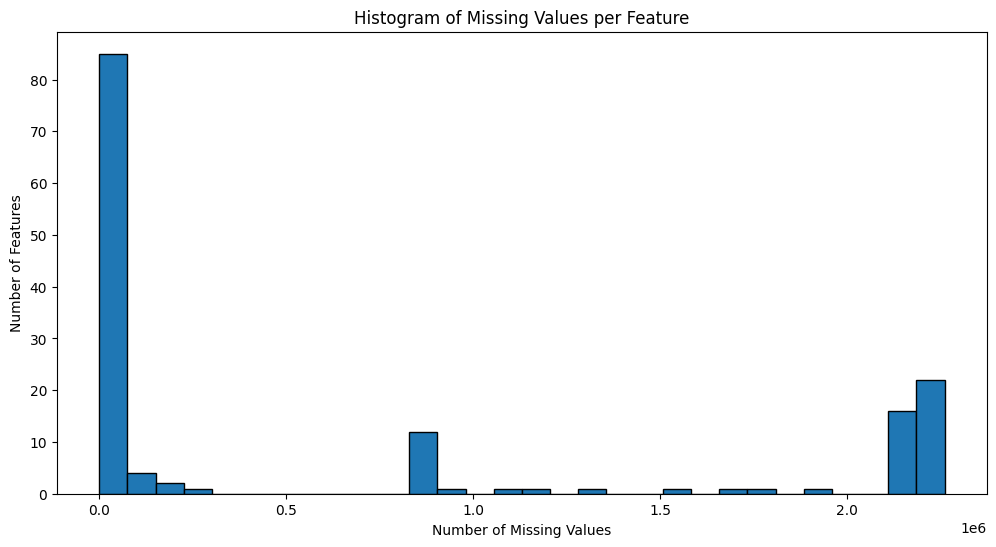

---

### Data Types

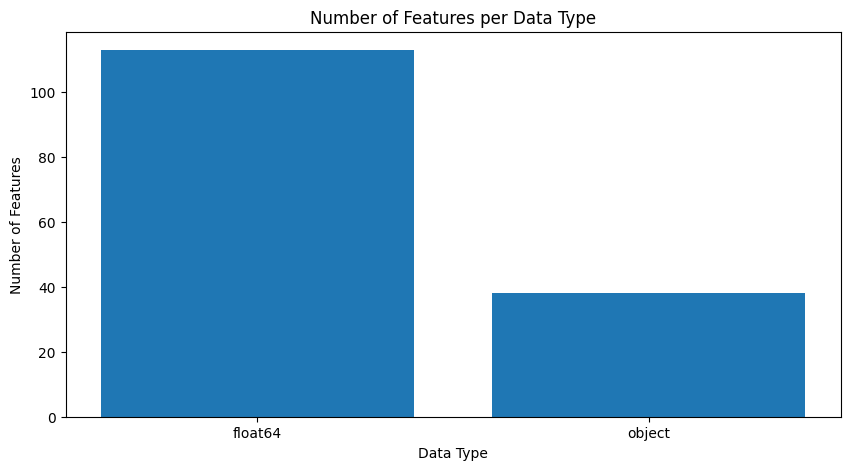

---

### Shape

(2260701, 151)

---

In [3]:
def Explore(df, show_missing=False ,show_dtypes=False, show_unique_count=False, show_shape=False):
    if show_missing:
        # Display count of all missing values in each column
        display(Markdown("### Missing Values"))
        
        # Sum of missing values in each column and convertion to a dataframe.
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0]

        # histogram
        plt.figure(figsize=(12, 6))
        plt.hist(missing_values.values, bins=30, edgecolor='black')  # adjust bins as needed
        plt.xlabel("Number of Missing Values")
        plt.ylabel("Number of Features")
        plt.title("Histogram of Missing Values per Feature")
        plt.show()
        display(Markdown("---"))    

    if show_dtypes:
        # Display data types
        display(Markdown("### Data Types"))

        # Identify data types
        data_types = df.dtypes
        
        # Count number of features per dtype
        dtype_counts = data_types.value_counts()

        # Barchart
        plt.figure(figsize=(10, 5))
        plt.bar(dtype_counts.index.astype(str), dtype_counts.values)
        plt.xlabel("Data Type")
        plt.ylabel("Number of Features")
        plt.title("Number of Features per Data Type")
        plt.show()        
        display(Markdown("---"))    

    if show_unique_count:
        # Display section header
        display(Markdown("### Number of Unique Values (Object Columns Only)"))
        
        # 1. Select only object columns
        object_cols = df.select_dtypes(include='object').columns
        
        # 2. Compute unique value counts for each object column
        unique_counts = df[object_cols].nunique()

        # 3. Plot a bar chart
        plt.figure(figsize=(12, 6))
        plt.bar(unique_counts.index, unique_counts.values)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Object Columns")
        plt.ylabel("Number of Unique Values")
        plt.title("Unique Value Counts per Object Column")
        plt.tight_layout()
        plt.show()        
        display(Markdown("---"))        

    if show_shape:
        display(Markdown("### Shape"))
        display(df.shape)
        display(Markdown("---"))

Explore(credit_df, show_missing=True ,show_dtypes=True, show_unique_count=False, show_shape=True)

### **Ideal Columns For Credit Risk Modelling in Real Time**
#### **Credit Risk Fundamentals**
- fico_range_low
- fico_range_high
- dti
- revol_util
- annual_inc
#### **Delinquency History** 
- delinq_2yrs
- pub_rec_bankruptcies
- inq_last_6mths
#### Loan Characteristics 
- loan_amnt
- int_rate
- term
#### Credit Profile 
- total_acc
- open_acc
- credit_age_month (engineered from earliest_cr_line)
#### Categorical 
- home_ownership
- purpose
- emp_length
- addr_state
- verification_status
#### Label
- loan_status


### **Insights From Analyzing Credit Data and How Credit Operates**
- Most of the other columns are generated behind the scenes by sending API calls to Credit Bureaus, which are companies that collect finanancial data on individuals and businesses in terms of loans, credit cards, payment hinstory, defaults, bankruptcies etc. e.g. TransUnion, Experian and Equifax.
- To create a real time system using streamlit I'll only be using relevant features that are applicable in real time such the detailed above.

### Missing Values

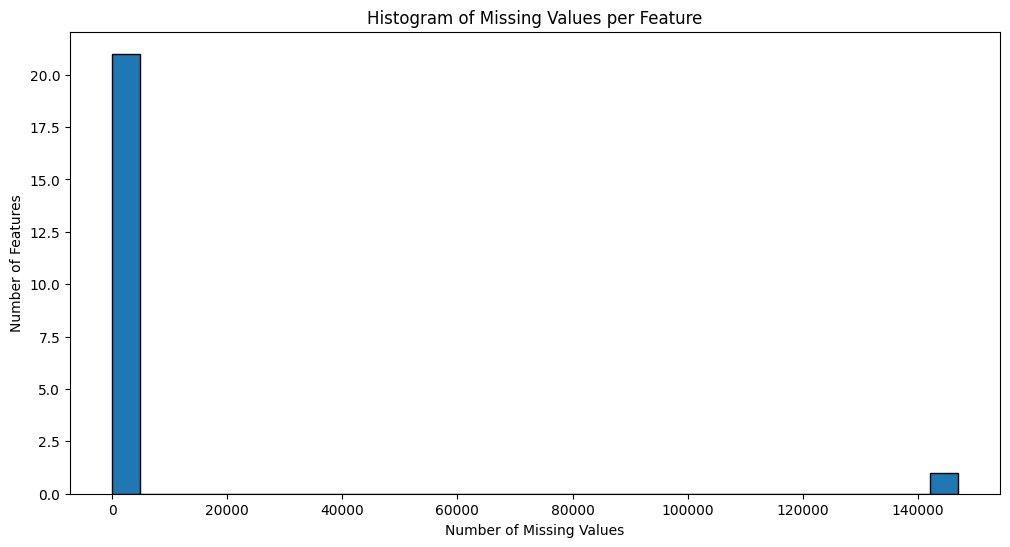

---

### Data Types

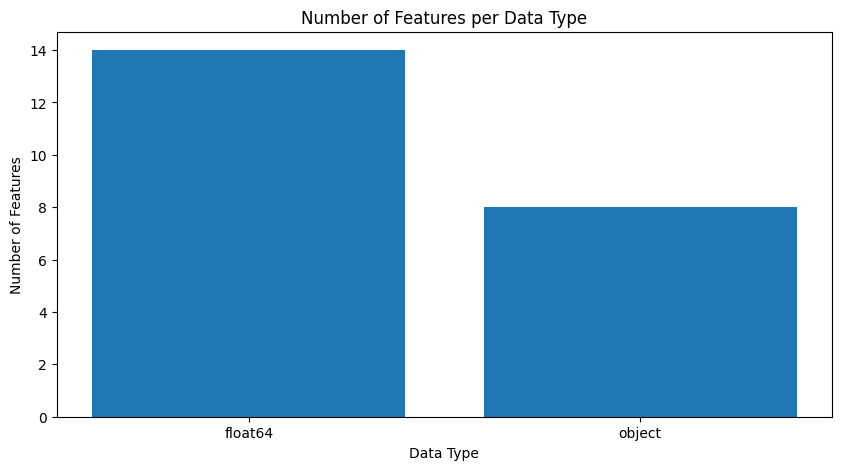

---

### Number of Unique Values (Object Columns Only)

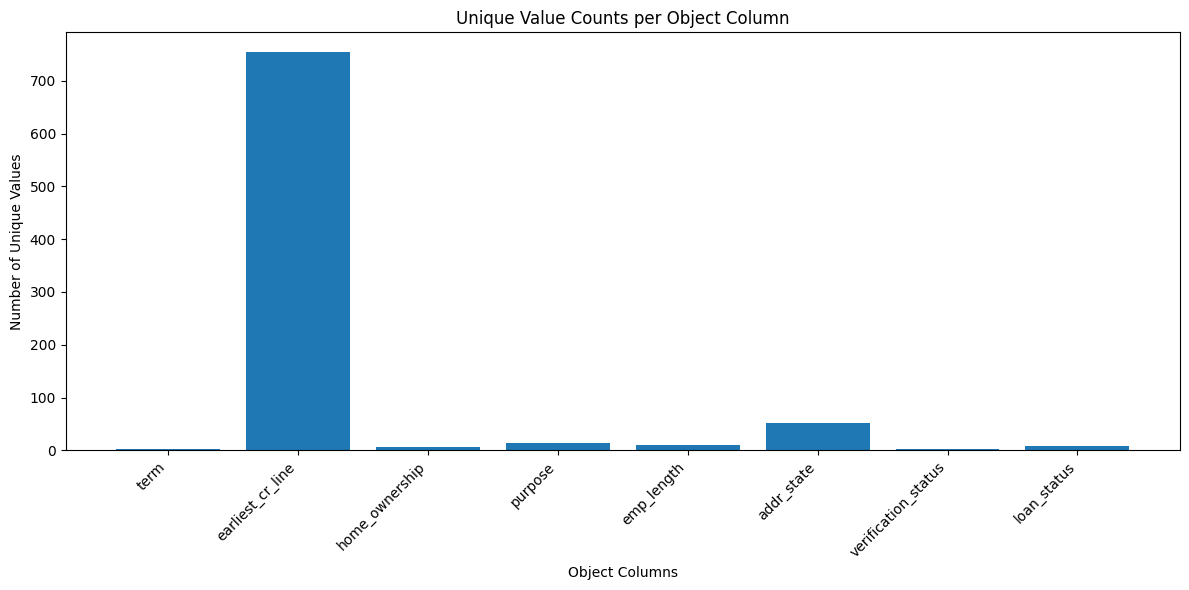

---

### Shape

(2260701, 22)

---

In [4]:
# Filter to only have relevant columns for further modelling
cols = ['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util', 'annual_inc', 'delinq_2yrs', 'pub_rec', 
        'pub_rec_bankruptcies', 'inq_last_6mths', 'loan_amnt', 'term', 'total_acc', 'open_acc', 'earliest_cr_line', 
        'home_ownership', 'purpose', 'emp_length', 'addr_state', 'verification_status', 'collections_12_mths_ex_med', 'loan_status']

relevant_credit_df = credit_df[cols]
Explore(relevant_credit_df, show_missing=True ,show_dtypes=True, show_unique_count=True, show_shape=True)

# Feature Engineering
---
### Row-Level Transformations Only

In [5]:
# Make a deep copy of relevant_credit_df
relevant_credit_df = relevant_credit_df.copy()

# Convert earliest_cr_line to datetime
relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
    relevant_credit_df['earliest_cr_line'])

# Get today's timestamp and calculate credit history in years
today = pd.Timestamp.today()
relevant_credit_df['credit_history_years'] = (
    (today - relevant_credit_df['earliest_cr_line']).dt.days / 365
)

# Income to loan ratio
relevant_credit_df['income_to_loan_ratio'] = relevant_credit_df['annual_inc'] / relevant_credit_df['loan_amnt']

# Fico score
relevant_credit_df['fico_score'] = (relevant_credit_df['fico_range_low'] + relevant_credit_df['fico_range_high']) /2

# Account utilization
relevant_credit_df['account_utilization'] = relevant_credit_df['open_acc'] / relevant_credit_df['total_acc']

# Avg credit per account
relevant_credit_df['avg_credit_per_account'] = np.where(
    relevant_credit_df['open_acc'] > 0,
    relevant_credit_df['revol_bal'] / relevant_credit_df['open_acc'],
    0
)

# Deliquency rate
relevant_credit_df['deliquency_rate'] = np.where(
    relevant_credit_df['total_acc'] > 0,
    relevant_credit_df['delinq_2yrs'] / relevant_credit_df['total_acc'],
    0
)

# Drop irrelavent features after engineering
relevant_credit_df.drop(columns='earliest_cr_line')

# Display engineered features
# relevant_credit_df[['credit_history_years', 'income_to_loan_ratio', 'fico_score', 'account_utilization', 'revol_bal','total_acc','open_acc', 'delinq_2yrs', 'deliquency_rate','avg_credit_per_account']].query("deliquency_rate > 0.4")

/tmp/ipykernel_214/1148206564.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_

,fico_range_low,fico_range_high,dti,revol_bal,revol_util,annual_inc,delinq_2yrs,pub_rec,pub_rec_bankruptcies,inq_last_6mths,...,addr_state,verification_status,collections_12_mths_ex_med,loan_status,credit_history_years,income_to_loan_ratio,fico_score,account_utilization,avg_credit_per_account,deliquency_rate
0,675.0,679.0,5.91,2765.0,29.7,55000.0,0.0,0.0,0.0,1.0,...,PA,Not Verified,0.0,Fully Paid,22.383562,15.277778,677.0,0.538462,395.000000,0.000000
1,715.0,719.0,16.06,21470.0,19.2,65000.0,1.0,0.0,0.0,4.0,...,SD,Not Verified,0.0,Fully Paid,26.052055,2.631579,717.0,0.578947,975.909091,0.026316
2,695.0,699.0,10.78,7869.0,56.2,63000.0,0.0,0.0,0.0,0.0,...,IL,Not Verified,0.0,Fully Paid,25.383562,3.150000,697.0,0.333333,1311.500000,0.000000
3,785.0,789.0,17.06,7802.0,11.6,110000.0,0.0,0.0,0.0,0.0,...,NJ,Source Verified,0.0,Current,17.293151,3.142857,787.0,0.764706,600.153846,0.000000
4,695.0,699.0,25.37,21929.0,64.5,104433.0,1.0,0.0,0.0,3.0,...,PA,Source Verified,0.0,Fully Paid,27.553425,10.041635,697.0,0.342857,1827.416667,0.028571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,705.0,709.0,12.75,8633.0,64.9,227000.0,7.0,0.0,0.0,1.0,...,CA,Verified,0.0,Current,30.884932,5.675000,707.0,0.135135,1726.600000,0.189189
2260697,660.0,664.0,18.30,17641.0,68.1,110000.0,0.0,1.0,1.0,0.0,...,FL,Not Verified,0.0,Charged Off,26.471233,4.583333,662.0,0.322581,1764.100000,0.000000
2260698,660.0,664.0,23.36,7662.0,54.0,95000.0,0.0,0.0,0.0,1.0,...,TX,Verified,0.0,Current,29.553425,6.785714,662.0,0.363636,957.750000,0.000000
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


### Target Encoding

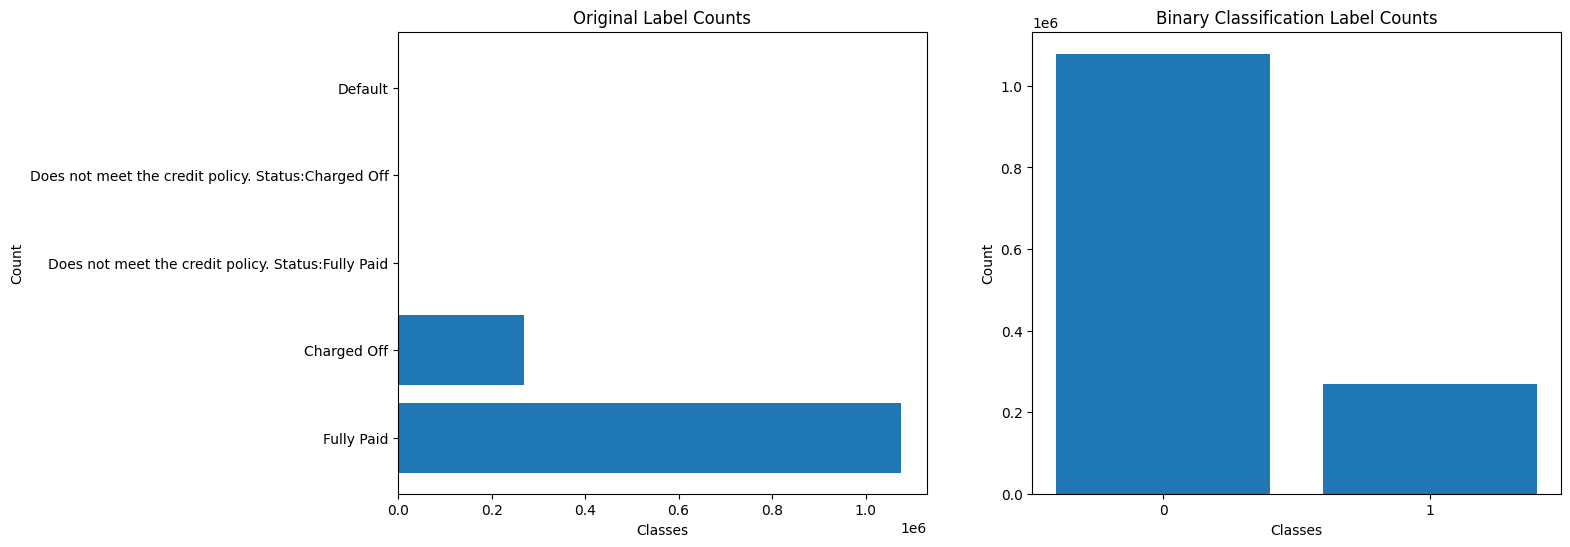

In [6]:
# Example: your loan status series
loan_status = pd.Series([
    'Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)',
    'In Grace Period', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off',
    'Default'
])

# Mapping to binary target
default_mapping = {
    'Charged Off': 1,
    'Default': 1,
    # 'Late (31-120 days)': 1,
    # 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0
    # 'Current': 0,              # include cautiously
    # 'In Grace Period': 0       # treat cautiously
}

# Defein the statuses to keep
statuses_to_keep = list(default_mapping.keys())

# Filter dataframe
relevant_credit_df = relevant_credit_df[relevant_credit_df['loan_status'].isin(statuses_to_keep)]

# Map the remaining statuses to 0 = paid and 1 = default
relevant_credit_df.loc[:, 'loan_status_binary'] = relevant_credit_df['loan_status'].map(default_mapping)


# plot a count based bar plot to identify class imbalance
loan_status_count         = relevant_credit_df['loan_status'].value_counts()
loan_status_binanry_count = relevant_credit_df['loan_status_binary'].value_counts()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].barh(loan_status_count.index.astype(str), loan_status_count.values)
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Count')
ax[0].set_title('Original Label Counts')

ax[1].bar(loan_status_binanry_count.index.astype(str), loan_status_binanry_count.values)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Count')
ax[1].set_title('Binary Classification Label Counts')

plt.show()


# Removing Data Quality Issues (Before Split)
---

In [7]:
# Assess how many rows are missing values across the selected 20 columns
# Count missing values accross columns, filter out those with no missing values and sort in descending order
null_count_per_row = relevant_credit_df.isnull().sum(axis=1)
null_count_per_row = null_count_per_row[null_count_per_row > 0]
null_count_per_row = null_count_per_row.sort_values(ascending=False)
display(null_count_per_row.value_counts())

1     80205
2       514
11       25
13        4
3         4
Name: count, dtype: int64

### Missing Values

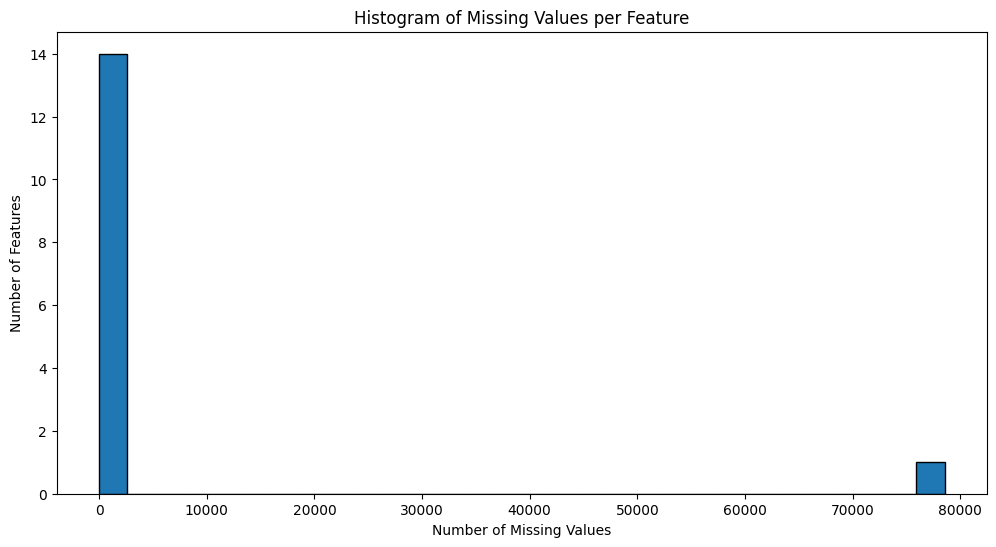

---

### Number of Unique Values (Object Columns Only)

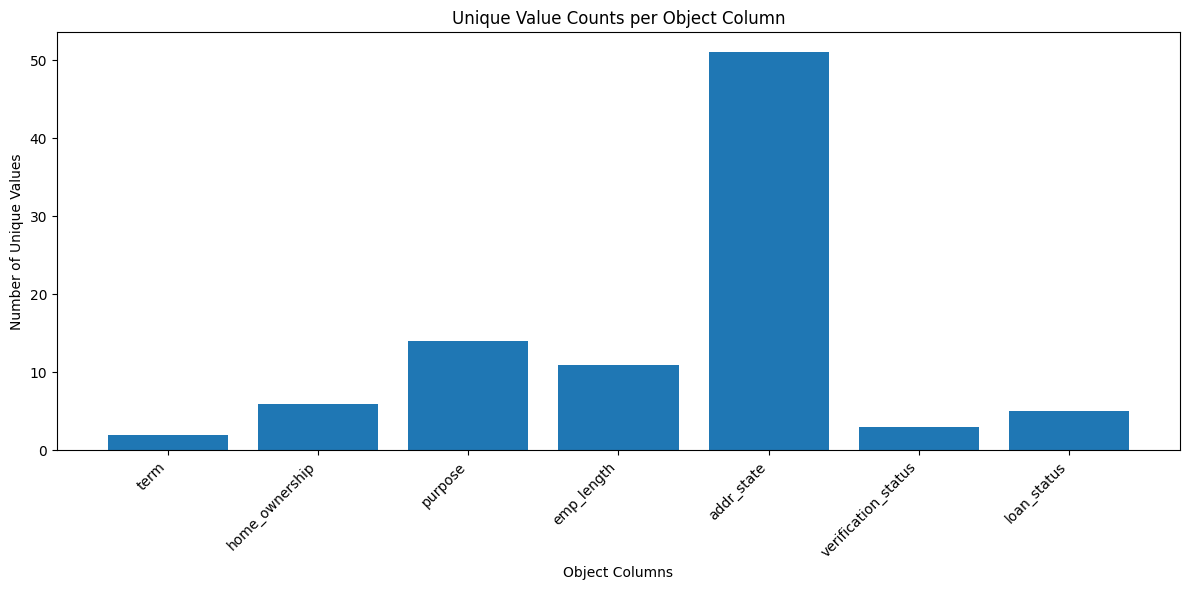

---

In [8]:
# Drop all rows with 20 missing values, essentially corrupt rows with no useable data
relevant_credit_df = relevant_credit_df.dropna(how='all')

# Re-examine data
Explore(relevant_credit_df, show_missing=True ,show_dtypes=False, show_unique_count=True, show_shape=False)

# Train-Test Split 
---

In [9]:
from sklearn.model_selection import train_test_split, KFold

In [10]:
X = relevant_credit_df.drop(columns=['loan_status', 'loan_status_binary'])
y = relevant_credit_df['loan_status_binary']

print(X.shape)
print(y.shape)

(1348099, 27)
(1348099,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (1078479, 27)
y train shape: (1078479,)
X test shape: (269620, 27)
y test shape: (269620,)


# Imputation and Encoding (After Data Splitting)
---

In [12]:
# !pip install imblearn

In [13]:
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

In [14]:
def create_preprocessor(X_train):
    """
    Create and fit a preprocessing pipeline for numeric and categorical features.
    
    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
        
    Returns
    -------
    preprocessor : ColumnTransformer
        Fitted preprocessor for transforming train, validation, or test data.
    """
    # Separate numeric and categorical columns
    numerical_cols = X_train.select_dtypes(include='number').columns
    categorical_cols = X_train.select_dtypes(include='object').columns
    
    print(f"Numeric Columns: {numerical_cols}")
    print(f"Categorical Columns: {categorical_cols}")
    
    # Create imputers
    numeric_imputer = SimpleImputer(strategy="median")
    categorical_imputer = SimpleImputer(strategy="most_frequent")
    
    # Numerical pipeline
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputer),
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline
    categorical_pipeline = Pipeline([
        ('imputer', categorical_imputer),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])
    
    # Fit preprocessor on training data
    preprocessor.fit(X_train)
    
    return preprocessor

preprocessor = create_preprocessor(X_train)

Numeric Columns: Index(['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util',
       'annual_inc', 'delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies',
       'inq_last_6mths', 'loan_amnt', 'total_acc', 'open_acc',
       'collections_12_mths_ex_med', 'credit_history_years',
       'income_to_loan_ratio', 'fico_score', 'account_utilization',
       'avg_credit_per_account', 'deliquency_rate'],
      dtype='object')
Categorical Columns: Index(['term', 'home_ownership', 'purpose', 'emp_length', 'addr_state',
       'verification_status'],
      dtype='object')


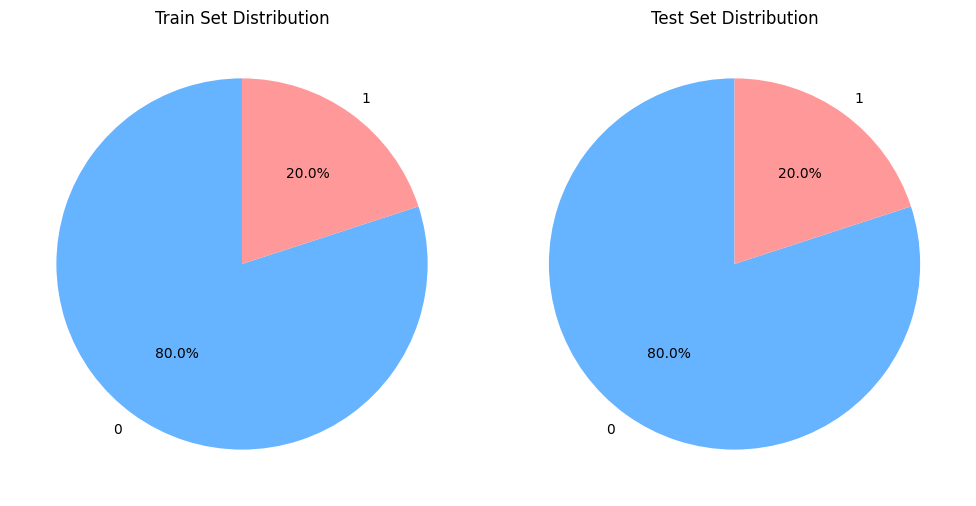

y train:  loan_status_binary
0    862991
1    215488
Name: count, dtype: int64

y test:  loan_status_binary
0    215748
1     53872
Name: count, dtype: int64


In [15]:
# Fit only on training data
preprocessor.fit(X_train)

# transform on all data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# After preproces.fit() and transform, extract feature names
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Class distributions
y_train_counts = y_train.value_counts()
y_test_counts  = y_test.value_counts()

# Define labels
labels = y_train_counts.index.astype(str)  # assuming classes are 0,1 etc.

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for training set
axes[0].pie(y_train_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[0].set_title("Train Set Distribution")

# Pie chart for test set
axes[1].pie(y_test_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[1].set_title("Test Set Distribution")

plt.tight_layout()
plt.show()

print("y train: ", y_train.value_counts())
print("\ny test: ", y_test.value_counts())

Correcting class imbalance using SMOTE
SMOTE took: 3.14 minutes

AFTER SMOTE:
y train resampled:  loan_status_binary
1    862991
0    862991
Name: count, dtype: int64


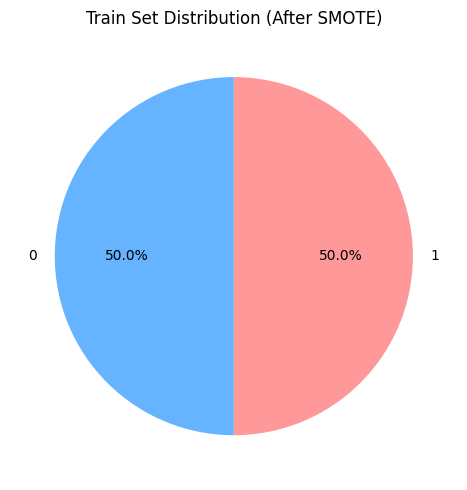

In [16]:
# ==================== SMOTE ====================
# Pure SMOTE
smote = SMOTE(random_state=42)
print("Correcting class imbalance using SMOTE")
smote_start_time = time.time()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
smote_end_time = time.time() - smote_start_time
print(f"SMOTE took: {(smote_end_time/60):.2f} minutes")

# Convert back to DataFrame for consistency
X_train_df_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)
y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)

print("\nAFTER SMOTE:")
print("y train resampled: ", y_train_resampled.value_counts())

# Visualize AFTER SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
y_train_resampled_counts = y_train_resampled.value_counts()
ax.pie(y_train_resampled_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
ax.set_title("Train Set Distribution (After SMOTE)")
plt.tight_layout()
plt.show()


# Explore Models
---

In [17]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.utils import class_weight

import shap

2025-12-13 12:57:55.856466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765630675.873902     214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765630675.879052     214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [18]:
def plot_shap_importance(model, X_train_preprocessed, model_name, feature_names=None):
    print(f"\nGenerating SHAP explanations for {model_name}...")
    
    # -------------------------------
    # 1. Convert to numpy array if DataFrame
    # -------------------------------
    if hasattr(X_train_preprocessed, 'values'):
        X_array = X_train_preprocessed.values
        if feature_names is None:
            feature_names = X_train_preprocessed.columns
    else:
        X_array = X_train_preprocessed
    
    # -------------------------------
    # 2. Clean feature names
    # -------------------------------
    if feature_names is not None:
        clean_feature_names = [str(f).replace('[','_').replace(']','').replace('<','_').replace('>','_') 
                               for f in feature_names]
    else:
        clean_feature_names = None
    
    # -------------------------------
    # 3. Sample data to speed up plotting
    # -------------------------------
    max_samples = 10000
    n_rows = X_array.shape[0]
    if n_rows > max_samples:
        idx = np.random.choice(n_rows, max_samples, replace=False)
        X_sample = X_array[idx]
    else:
        X_sample = X_array
    
    # -------------------------------
    # 4. Create SHAP explainer
    # -------------------------------
    if "logistic regression" in model_name.lower():
        explainer = shap.LinearExplainer(model, X_sample)
    elif "neural" in model_name.lower() or "nn" in model_name.lower():
        explainer = shap.Explainer(model, X_sample)
    else:
        explainer = shap.TreeExplainer(model)
    
    # -------------------------------
    # 5. Compute SHAP values
    # -------------------------------
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, handle output format
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # -------------------------------
    # 6. Plot SHAP summary plots - SEPARATE FIGURES
    # -------------------------------
    
    # Bar plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      plot_type="bar", 
                      show=False)
    plt.title(f"SHAP Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()
    
    # Dot plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      show=False)
    plt.title(f"SHAP Summary Plot - {model_name}")
    plt.tight_layout()
    plt.show()
    
    return shap_values

In [19]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a Keras or scikit-learn binary classification model.
    
    Args:
        model : trained Keras model or sklearn classifier
        X_test : numpy array or pandas DataFrame of test features
        y_test : true labels for the test set
    Returns:
        dict of key metrics (best_threshold, best_f1, accuracy, roc_auc)
    """
    # Predict probabilities
    if isinstance(model, tf.keras.Model):  # Keras Functional or Sequential model
        y_pred_proba = model.predict(X_test).flatten()
    else:  # Assume scikit-learn classifier
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall and F1
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    print(f"Best threshold: {best_threshold:.3f}, Best F1-score: {best_f1:.3f}")
    
    # Apply threshold for binary predictions
    y_pred_opt = (y_pred_proba >= best_threshold).astype(int)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred_opt)
    print(f"Accuracy: {acc:.2f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_opt))
    
    # ROC-AUC
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_opt)
    
    # ================== Plots ==================
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    
    # Confusion matrix heatmap
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Predicted Paid', 'Predicted Default'],
                yticklabels=['Actual Paid', 'Actual Default'])
    ax[0].set_title('Test Set Confusion Matrix')
    ax[0].set_ylabel('True Label')
    ax[0].set_xlabel('Predicted Label')
    
    # ROC curve
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
    ax[1].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_roc_auc:.4f})', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='lower right')
    ax[1].grid(alpha=0.3)
    
    # Precision-Recall curve
    ax[2].plot(recall, precision, label='PR Curve')
    ax[2].scatter(recall[best_idx], precision[best_idx], color='red', 
                  label=f'Best threshold={best_threshold:.3f}')
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].set_title("Precision-Recall Curve")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    return {
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "accuracy": acc,
        "roc_auc": test_roc_auc
    }
    

Training LGBM Classifier
[LightGBM] [Info] Number of positive: 862991, number of negative: 862991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.594296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23722
[LightGBM] [Info] Number of data points in the train set: 1725982, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Classifier took 0.34 minutes or 20.44 seconds



X does not have valid feature names, but LGBMClassifier was fitted with feature names


Best threshold: 0.231, Best F1-score: 0.414
Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    215748
           1       0.31      0.63      0.41     53872

    accuracy                           0.64    269620
   macro avg       0.59      0.64      0.58    269620
weighted avg       0.76      0.64      0.68    269620



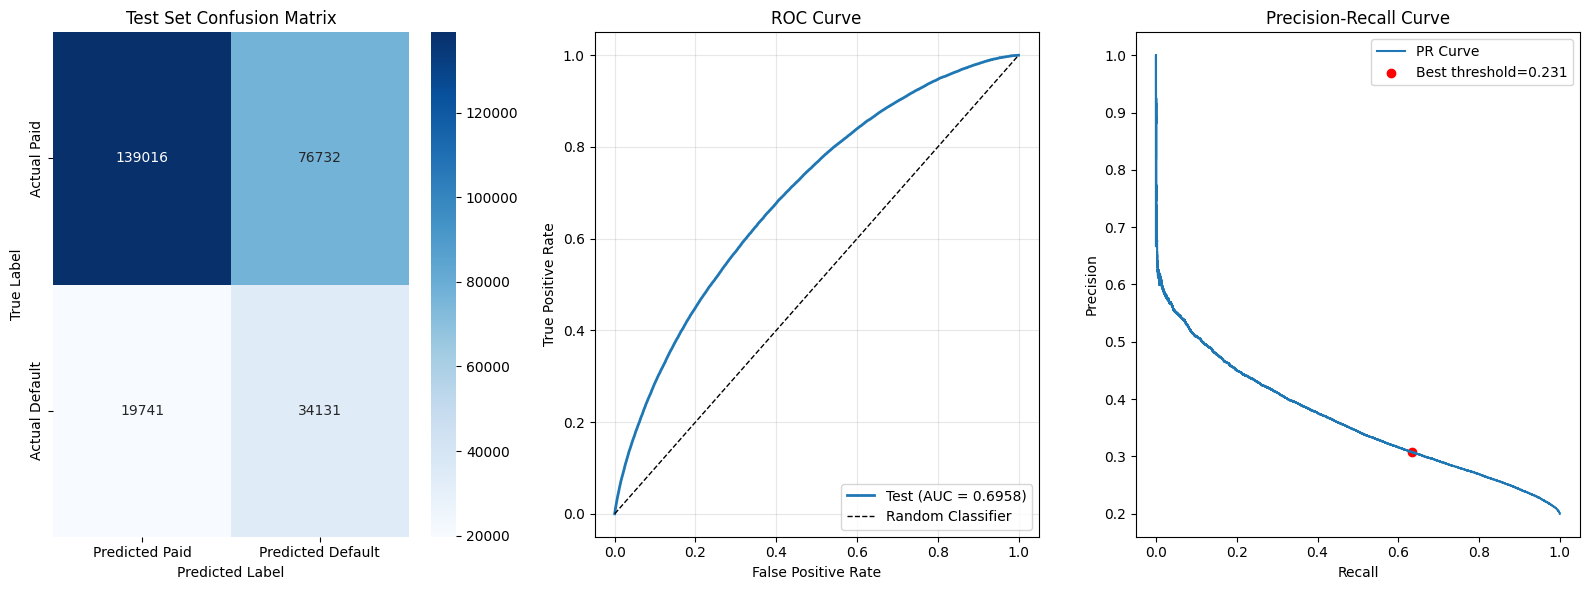


Generating SHAP explanations for LGBM Classifier...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


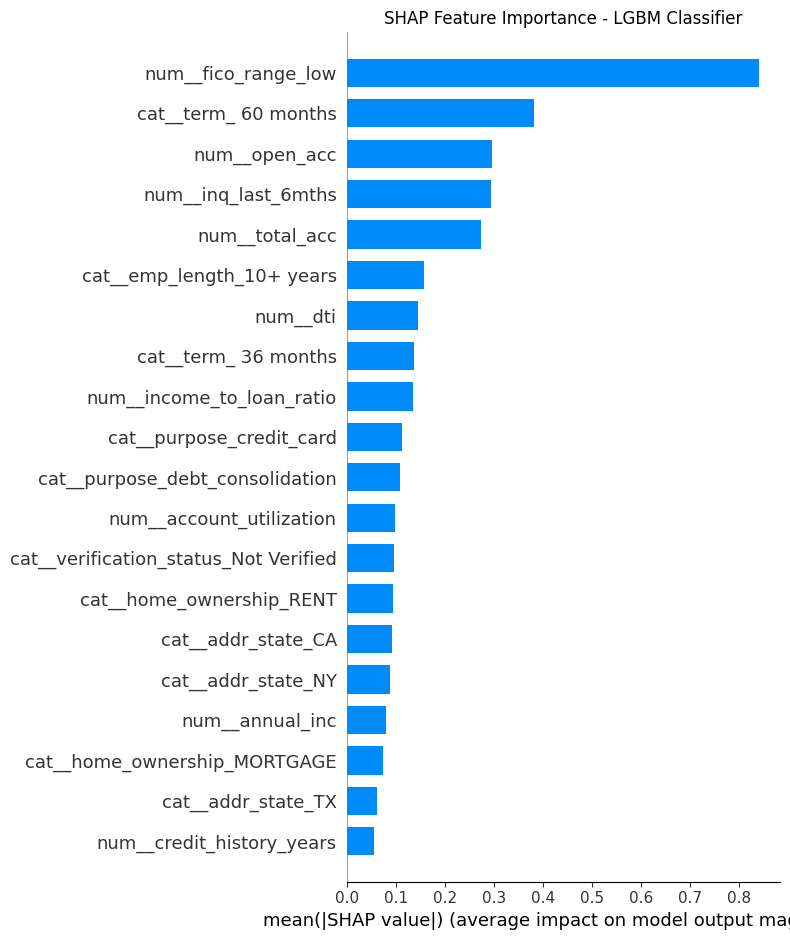

The figure layout has changed to tight


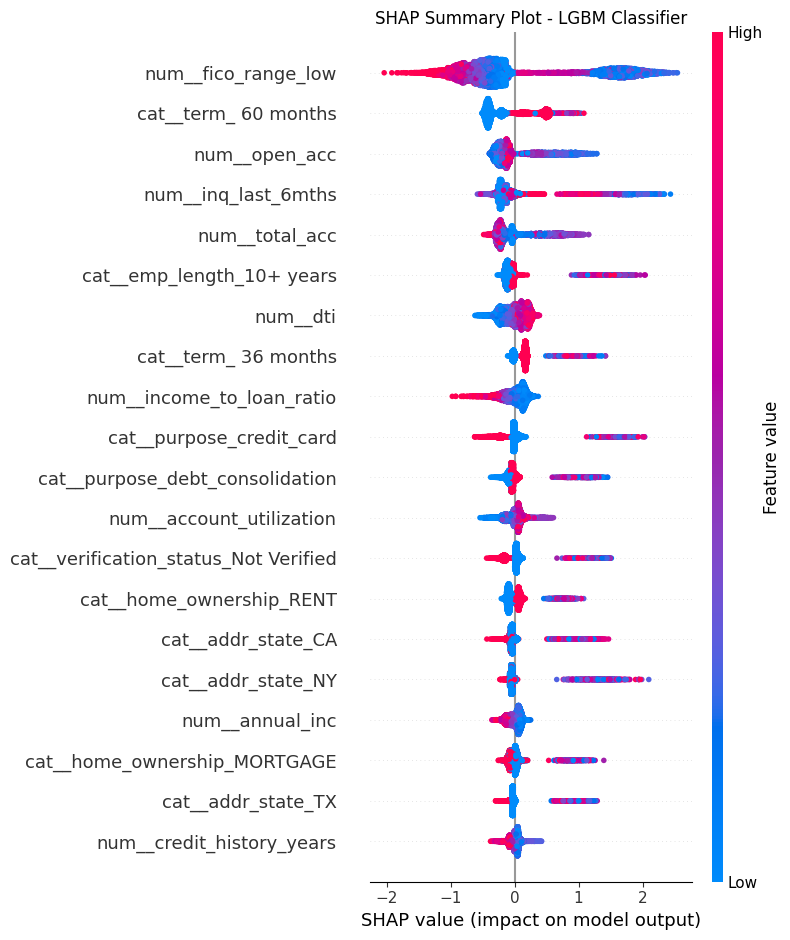

Shap analysis for LGBM Classifier took 0.10 minutes or 5.79 seconds
Training Cat Boost Classifier
Cat Boost Classifier took 1.58 minutes or 94.51 seconds

Best threshold: 0.242, Best F1-score: 0.414
Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.66      0.75    215748
           1       0.31      0.61      0.41     53872

    accuracy                           0.65    269620
   macro avg       0.59      0.64      0.58    269620
weighted avg       0.76      0.65      0.69    269620



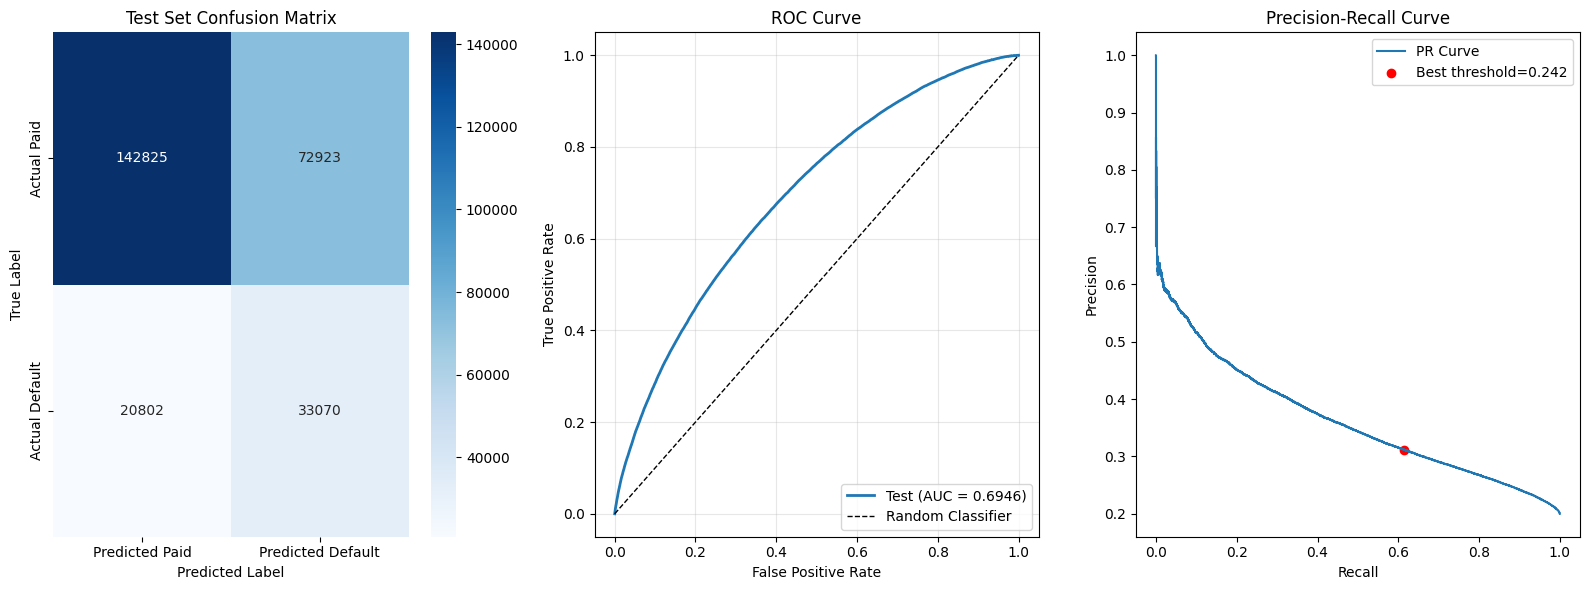


Generating SHAP explanations for Cat Boost Classifier...


The figure layout has changed to tight


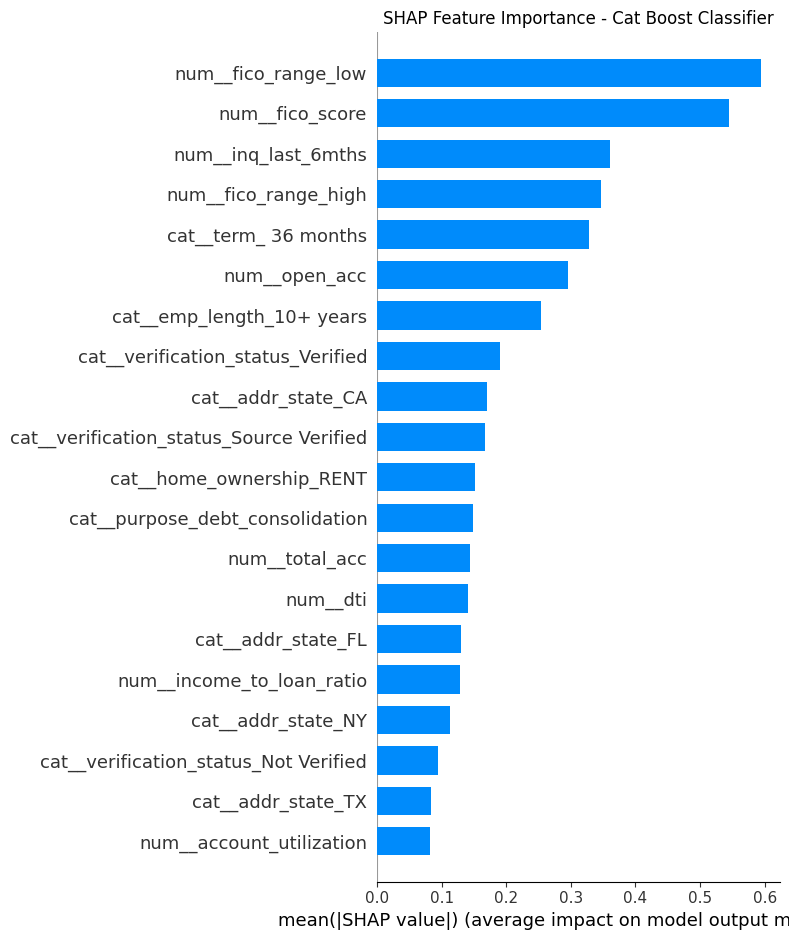

The figure layout has changed to tight


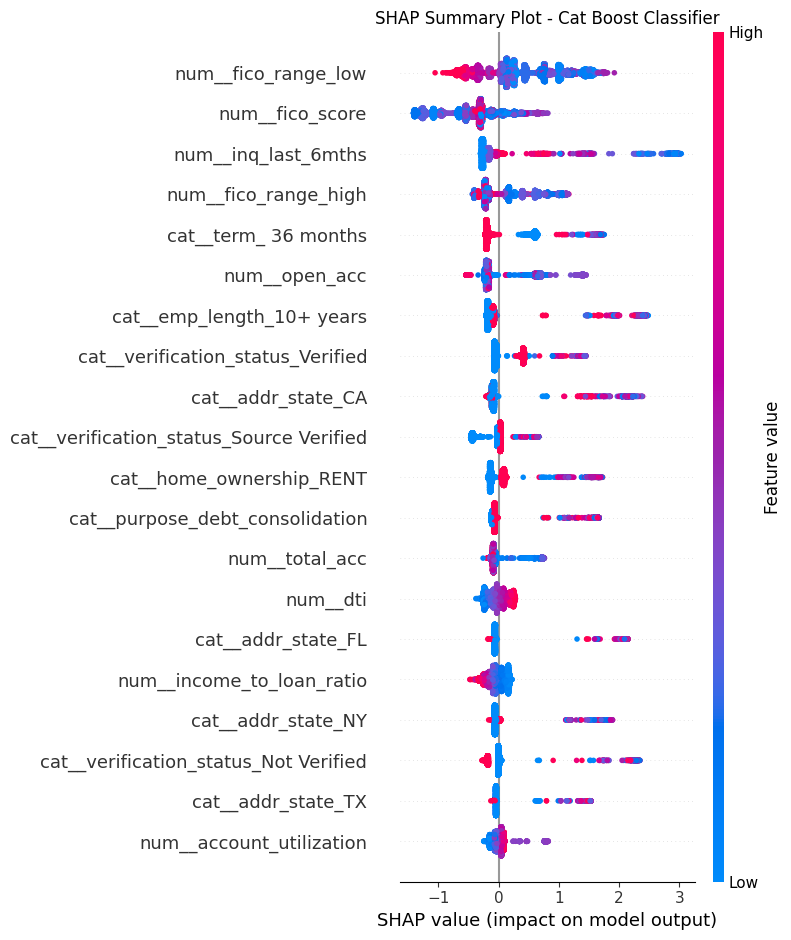

Shap analysis for Cat Boost Classifier took 0.05 minutes or 3.15 seconds


In [20]:
models = {
    # 'Logistic Regression' : LogisticRegression(
    #                             max_iter=1000, 
    #                             random_state=42),
    # 'XGB Classifier' : xgb.XGBClassifier(
    #                     n_estimators=100,
    #                     learning_rate=0.1,
    #                     max_depth=6,
    #                     random_state=42,
    #                     use_label_encoder=False,
    #                     eval_metric='logloss'),
    'LGBM Classifier' : lgb.LGBMClassifier(
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=-1,
                        random_state=42),
    'Cat Boost Classifier' : CatBoostClassifier(
                                iterations=100,
                                learning_rate=0.1,
                                depth=6,
                                random_seed=42,
                                verbose=0)  
    # 'Random Forest Classifier' : RandomForestClassifier(
    #                                 n_estimators=100,
    #                                 max_depth=10,
    #                                 random_state=42,
    #                                 n_jobs=-1
    #                             )
}

# Save trained models
trained_models = {}

for model_name, model in models.items():
    print("=" * 60)
    print(f"Training {model_name}")
    print("=" * 60)

    # Train models and timing each individually.
    model_training_start = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    model_training_end = time.time() - model_training_start
    print(f"{model_name} took {(model_training_end/60):.2f} minutes or {model_training_end:.2f} seconds\n")

    # Store the trained model
    trained_models[model_name] = model

    model_metrics = evaluate_model(model, X_test_preprocessed, y_test)

    # ================== SHAP Feature Importance ==================
    try:
        model_shap_analysis_start = time.time()
        shap_values = plot_shap_importance(
            model=model,
            X_train_preprocessed=X_train_df_resampled,
            model_name=model_name,
            feature_names=X_train_df_resampled.columns 
        )
        model_shap_analysis_end = time.time() - model_shap_analysis_start
        print(f"Shap analysis for {model_name} took {(model_shap_analysis_end/60):.2f} minutes or {model_shap_analysis_end:.2f} seconds")
    except Exception as e:
        print(f"SHAP failed for {model_name}: {e}")

In [21]:
def create_meta_features(models, X_train, y_train, X_test, n_folds=5):
    """
    Create meta-features using out-of-fold predictions for training
    and full model predictions for test set.

    Parameters:
    ----------
    models : dict
        Dictionary of untrained base models
    X_train : array-like 
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    n_folds : int
        Number of folds for cross-validation

    Returns:
    --------
    meta-train : array
        Out-of-fold predictions for training (n_samples, n_models)
    meta-test : array
        Average predictions for test set (n_samples, n_models)
    """
    n_models = len(models)
    n_train  = X_train.shape[0]
    n_test   = X_test.shape[0]

    # Initialize arrays
    meta_train = np.zeros((n_train, n_models))
    meta_test  = np.zeros((n_test, n_models))

    # K-Fold cross-validation
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f"Processing {model_name}...")

        # Array to store test predictions for each fold
        test_preds_folds = np.zeros((n_test, n_folds))

        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
            # Split data
            X_fold_train = X_train[train_idx] 
            y_fold_train = y_train[train_idx]
            X_fold_val   = X_train[val_idx]

            # Clone and train model on fold
            from sklearn.base import clone
            fold_model = clone(model)
            print(f"Training fold {fold_idx+1}")
            fold_model.fit(X_fold_train, y_fold_train)

            # Out-of-fold predictions for meta_training
            meta_train[val_idx, model_idx] = fold_model.predict_proba(X_fold_val)[:,1]

            # Predictions on test set (to be averaged)
            test_preds_folds[:, fold_idx] = fold_model.predict_proba(X_test)[:,1]

        # Average test predictions across folds
        meta_test[:, model_idx] = test_preds_folds.mean(axis=1)

    return meta_train, meta_test


## Neural Network
---

In [22]:
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(X, y, test_size=0.3, random_state=41, stratify=y)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_temp_nn, y_temp_nn, test_size=0.5, random_state=41, stratify=y_temp_nn)

print(f"X train shape: {X_train_nn.shape}")
print(f"y train shape: {y_train_nn.shape}")
print(f"X val shape: {X_val_nn.shape}")
print(f"y val shape: {y_val_nn.shape}")
print(f"X test shape: {X_test_nn.shape}")
print(f"y test shape: {y_test_nn.shape}")

X train shape: (943669, 27)
y train shape: (943669,)
X val shape: (202215, 27)
y val shape: (202215,)
X test shape: (202215, 27)
y test shape: (202215,)


In [23]:
nn_preprocessor = create_preprocessor(X_train_nn)

Numeric Columns: Index(['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util',
       'annual_inc', 'delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies',
       'inq_last_6mths', 'loan_amnt', 'total_acc', 'open_acc',
       'collections_12_mths_ex_med', 'credit_history_years',
       'income_to_loan_ratio', 'fico_score', 'account_utilization',
       'avg_credit_per_account', 'deliquency_rate'],
      dtype='object')
Categorical Columns: Index(['term', 'home_ownership', 'purpose', 'emp_length', 'addr_state',
       'verification_status'],
      dtype='object')


In [24]:
# transform on all data
X_train_preprocessed_nn = nn_preprocessor.transform(X_train_nn)
X_val_preprocessed_nn = nn_preprocessor.transform(X_val_nn)
X_test_preprocessed_nn = nn_preprocessor.transform(X_test_nn)

# Convert to float32 for faster training
X_train_preprocessed_nn = X_train_preprocessed_nn.astype("float32")
X_val_preprocessed_nn   = X_val_preprocessed_nn.astype("float32")
X_test_preprocessed_nn  = X_test_preprocessed_nn.astype("float32")

# Reshape labels for consistency
y_train_nn = y_train_nn.values.reshape(-1, 1)
y_val_nn   = y_val_nn.values.reshape(-1, 1)
y_test_nn  = y_test_nn.values.reshape(-1, 1)

print(f"X train preprocessed shape: {X_train_preprocessed_nn.shape}")
print(f"X val preprocessed shape: {X_val_preprocessed_nn.shape}")
print(f"X test preprocessed shape: {X_test_preprocessed_nn.shape}")

print(f"y train shape: {y_train_nn.shape}")
print(f"y val shape: {y_val_nn.shape}")
print(f"y test shape: {y_test_nn.shape}")

nn_feature_names = nn_preprocessor.get_feature_names_out()

X train preprocessed shape: (943669, 107)
X val preprocessed shape: (202215, 107)
X test preprocessed shape: (202215, 107)
y train shape: (943669, 1)
y val shape: (202215, 1)
y test shape: (202215, 1)


In [25]:
def create_nn_model(input_dim):
    inputs  = tf.keras.Input(shape=(input_dim,), name="model_input")
    x       = layers.Dense(64, activation="relu", name="dense_64")(inputs)
    x       = layers.Dense(32, activation="relu", name="dense_32")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="default_probability")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lending_club_nn")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[metrics.AUC(name="auc")]
    )
    return model

In [26]:
# -------------------------------
# 1. Source number of features
# -------------------------------
input_dim = X_train_preprocessed_nn.shape[1]

# -------------------------------
# 2. Create the model using the function
# -------------------------------
model = create_nn_model(input_dim)

# -------------------------------
# 3. Early stopping callback - monitor validation AUC
# -------------------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,  # Increased from 3
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# 4. Learning rate scheduler
# -------------------------------
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# -------------------------------
# 5. Calculate class weights automatically
# -------------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_nn),
    y=y_train_nn.ravel()
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# -------------------------------
# 6. Fit the model
# -------------------------------
history = model.fit(
    X_train_preprocessed_nn, y_train_nn,
    validation_data=(X_val_preprocessed_nn, y_val_nn),
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

I0000 00:00:1765630833.755029     214 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765630833.755755     214 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Class weights: {0: 0.6248495266296481, 1: 2.502410475624761}
Epoch 1/50


I0000 00:00:1765630837.015472     284 service.cc:148] XLA service 0x30682fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765630837.015908     284 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765630837.015929     284 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765630837.264720     284 cuda_dnn.cc:529] Loaded cuDNN version 90300


  62/3687 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.5247 - loss: 0.6912  

I0000 00:00:1765630838.266381     284 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3687/3687 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - auc: 0.5955 - loss: 0.6787 - val_auc: 0.6674 - val_loss: 0.6572 - learning_rate: 1.0000e-05
Epoch 2/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6745 - loss: 0.6483 - val_auc: 0.6829 - val_loss: 0.6420 - learning_rate: 1.0000e-05
Epoch 3/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6868 - loss: 0.6382 - val_auc: 0.6888 - val_loss: 0.6363 - learning_rate: 1.0000e-05
Epoch 4/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6925 - loss: 0.6353 - val_auc: 0.6917 - val_loss: 0.6343 - learning_rate: 1.0000e-05
Epoch 5/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6946 - loss: 0.6334 - val_auc: 0.6934 - val_loss: 0.6328 - learning_rate: 1.0000e-05
Epoch 6/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6959 - loss: 0.6315 - val_auc: 0.6947 - val_loss: 0.6336 - learning_rate: 1.0000e-05
Epoch 7/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6973 - loss: 0.6301 - val_auc: 0.6956 - val_loss: 0.6

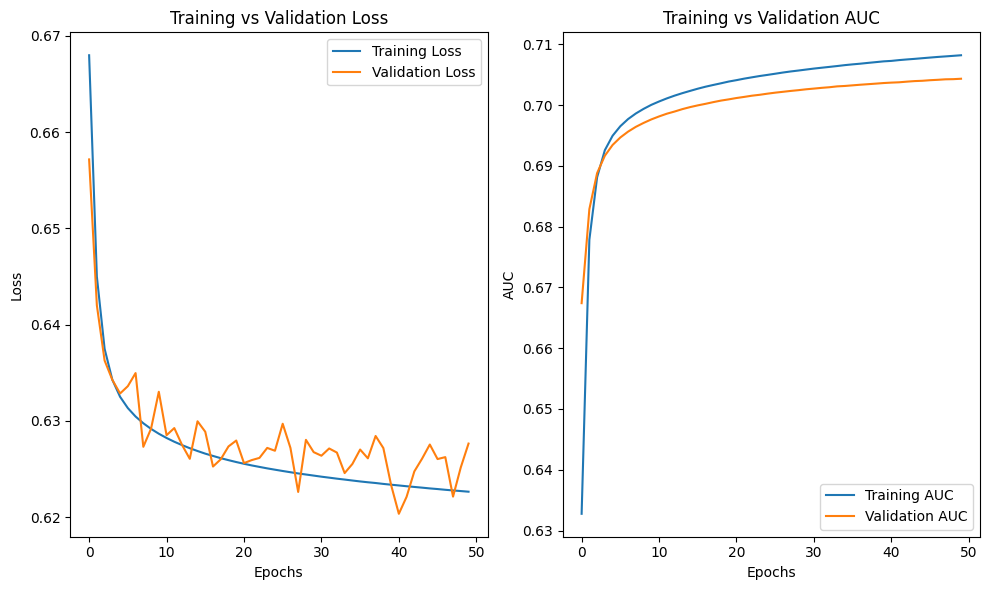

6320/6320 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Best threshold: 0.529, Best F1-score: 0.424
Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77    161811
           1       0.33      0.61      0.42     40404

    accuracy                           0.67    202215
   macro avg       0.60      0.65      0.60    202215
weighted avg       0.77      0.67      0.70    202215



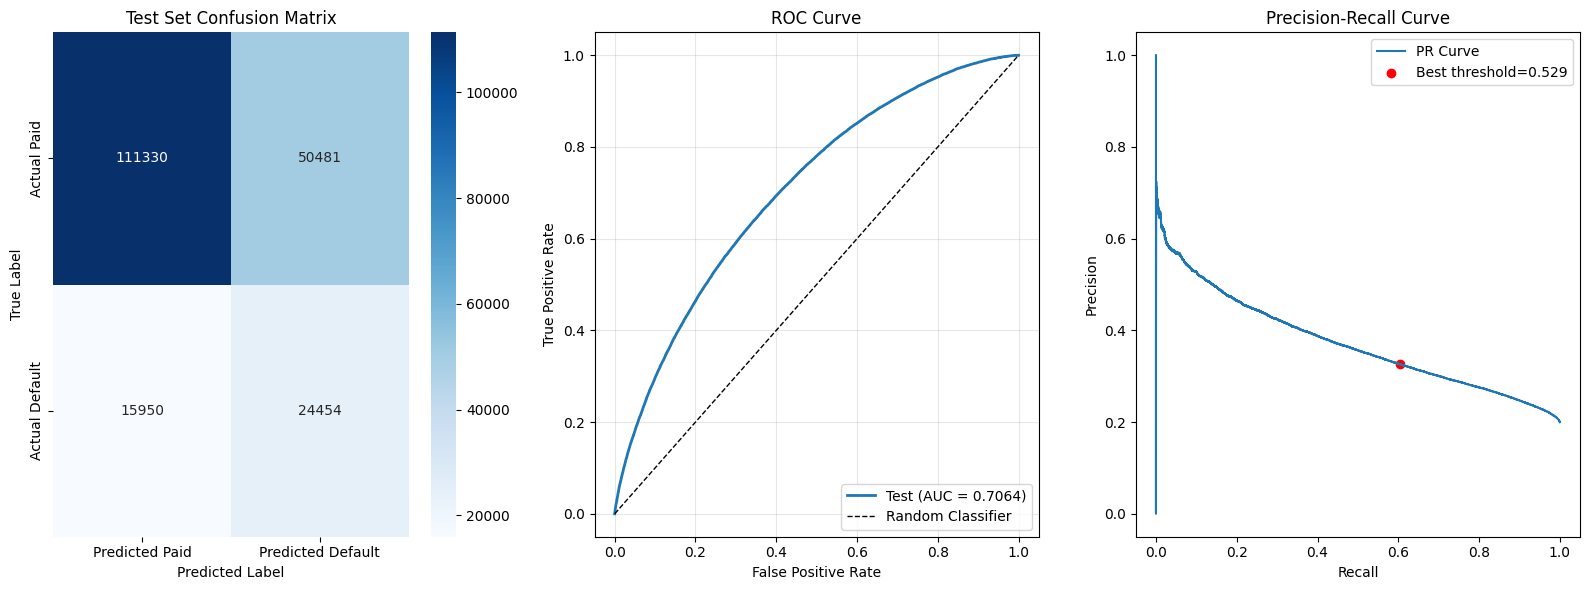


Generating SHAP explanations for Neural Network...


PermutationExplainer explainer:  77%|███████▋  | 7684/10000 [09:01<02:45, 13.96it/s]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Loss plot
ax[0].plot(history.history["loss"], label="Training Loss")
ax[0].plot(history.history["val_loss"], label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Training vs Validation Loss")

# AUC plot
ax[1].plot(history.history["auc"], label="Training AUC")
ax[1].plot(history.history["val_auc"], label="Validation AUC")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("AUC")
ax[1].legend()
ax[1].set_title("Training vs Validation AUC")

plt.tight_layout()
plt.show()

nn_metrics = evaluate_model(model, X_test_preprocessed_nn, y_test_nn)

# ================== SHAP ANALYSIS ==================
nn_shap_analysis_start = time.time()
shap_values = plot_shap_importance(
    model=model,
    X_train_preprocessed=X_train_preprocessed_nn,
    model_name="Neural Network",
    feature_names=nn_feature_names
)
nn_shap_analysis_end = time.time() - nn_shap_analysis_start
print(f"Shap analysis for neural network took {(nn_shap_analysis_end/60):.2f} minutes or {nn_shap_analysis_end:.2f} seconds")

## LightGBM, Cat Boost and Neural Network Ensemble
---

In [ ]:
# -------------------------------
# 1. Generate meta-features for the neural network using K-Fold
# -------------------------------
meta_train_nn = np.zeros((X_train_preprocessed.shape[0], 1))
meta_test_nn  = np.zeros((X_test_preprocessed.shape[0], 1))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train_preprocessed):
    X_fold_train = X_train_preprocessed[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val   = X_train_preprocessed[val_idx]

    nn = create_nn_model(input_dim)  # same architecture
    nn.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_train[val_idx]),
        epochs=50,
        batch_size=256,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    meta_train_nn[val_idx] = nn.predict(X_fold_val)
    meta_test_nn += nn.predict(X_test_preprocessed) / kf.n_splits

In [ ]:
# -------------------------------
# 2. Generate meta-features for base models (LGBM, CatBoost, etc.)
# -------------------------------
meta_train_base, meta_test_base = create_meta_features(
    models=models, 
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    X_test=X_test_preprocessed,
    n_folds=5
)

# -------------------------------
# 3. Combine base model meta-features with NN meta-features
# -------------------------------
meta_train_combined = np.hstack([meta_train_base, meta_train_nn])
meta_test_combined  = np.hstack([meta_test_base, meta_test_nn])

# -------------------------------
# 4. Train meta-model
# -------------------------------
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_train_combined, y_train_resampled)

# -------------------------------
# 5. Evaluate meta-model
# -------------------------------
metrics = evaluate_model(meta_model, meta_test_combined, y_test)

# -------------------------------
# 6. SHAP analysis for meta-model
# -------------------------------
meta_feature_names = list(models.keys()) + ["Neural Network"]

meta_model_shap_analysis_start = time.time()
shap_values = plot_shap_importance(
    model=meta_model,
    X_train_preprocessed=meta_train_combined,
    model_name="Logistic Regression Meta Model",
    feature_names=meta_feature_names
)
meta_model_shap_analysis_end = time.time() - meta_model_shap_analysis_start
print(f"SHAP analysis for meta-model took {(meta_model_shap_analysis_end/60):.2f} minutes or {meta_model_shap_analysis_end:.2f} seconds")

## Fully Trained Neural Network
---

In [ ]:
# Convert to float32 for faster training
X_train_preprocessed = X_train_preprocessed.astype("float32")
X_test_preprocessed  = X_test_preprocessed.astype("float32")

# Reshape labels for consistency
y_train = y_train.values.reshape(-1, 1)
y_test  = y_test.values.reshape(-1, 1)

print(f"X train preprocessed shape: {X_train_preprocessed.shape}")
print(f"X test preprocessed shape: {X_test_preprocessed.shape}")

print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

In [ ]:
# -------------------------------
# 1. Source number of features
# -------------------------------
input_dim = X_train_preprocessed.shape[1]

# -------------------------------
# 2. Create the model using the function
# -------------------------------
full_nn_model = create_nn_model(input_dim)

# -------------------------------
# 3. Calculate class weights automatically
# -------------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.ravel()
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# -------------------------------
# 4. Fit the model
# -------------------------------
full_nn_model.fit(
    X_train_preprocessed, y_train,
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

# Save Model and Preprocessor
---

In [ ]:
import pickle

In [ ]:
print("\n" + "=" * 60)
print("SAVING ENSEMBLE MODEL")
print("=" * 60)

# Save tree-based models in a dictionary
ensemble_models = {
    'LGBM Classifier': trained_models['LGBM Classifier'],
    'Cat Boost Classifier': trained_models['Cat Boost Classifier']
}

with open('ensemble_models.pkl', 'wb') as f:
    pickle.dump(ensemble_models, f)
print("✓ Tree-based models saved as 'ensemble_models.pkl'")

# Save the neural network separately
full_nn_model.save('nn_model.h5')
print("✓ Neural Network model saved as 'nn_model.h5'")

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preproces, f)
print("✓ Preprocessor saved as 'preprocessor.pkl'")

# Save best threshold
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)
print(f"✓ Best threshold ({best_threshold:.3f}) saved as 'best_threshold.pkl'")

print("\nModel artifacts saved successfully!")